# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
!pip install wheel==0.38.4
!pip install setuptools==66
!pip install gym==0.21.0

import os

In [2]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [4]:
policy = np.empty((n_states,n_actions))
policy.fill(1./n_actions)
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [28]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        a = np.random.choice(range(n_actions), p = policy[s])

        new_s,r,done,info = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        #Record state, action and add up reward to states,actions and total_reward accordingly.
        #add state
        #add action
        #add reward

        s = new_s
        if done:
            break
    return states,actions,total_reward


In [6]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.double]

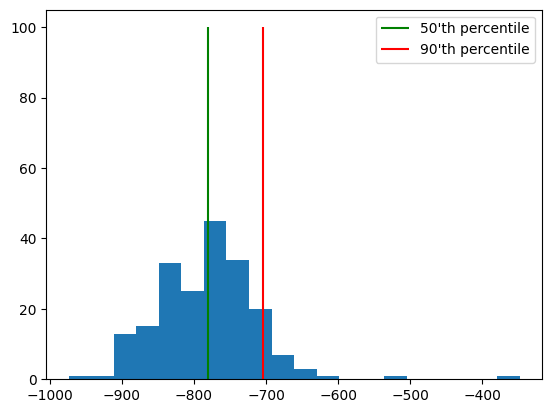

In [7]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (1pts)

In [8]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    reward_threshold = np.percentile(rewards_batch,percentile)

    elite_states = []

    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(states_batch[rewards_batch >= reward_threshold])
    else:
        elite_states = np.vstack(states_batch[rewards_batch >= reward_threshold])
    elite_actions = np.hstack(actions_batch[rewards_batch >= reward_threshold])

    return elite_states,elite_actions


In [9]:
states_batch = np.array([
    np.array([1,2,3]),   #game1
    np.array([4,2,0,2]), #game2
    np.array([3,1])      #game3
], np.ndarray)

actions_batch = np.array([
    np.array([0,2,4]),   #game1
    np.array([3,2,0,1]), #game2
    np.array([3,3])      #game3
], np.ndarray)
rewards_batch = np.array([
    3,         #game1
    4,         #game2
    5,         #game3
])

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [10]:
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros((n_states,n_actions))
    states_visits = np.zeros(n_states)
    np.add.at(states_visits, elite_states, 1)
    np.add.at(new_policy, (elite_states, elite_actions), 1)
    new_policy[states_visits==0] = 1./n_actions
    new_policy[states_visits!=0] /= states_visits[states_visits!=0,None]


    #<Your code here: update probabilities for actions given elite states & actions>
    #Don't forget to set 1/n_actions for all actions in unvisited states.

    return new_policy

In [11]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])

new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

In [12]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log, reward_range=[-990,+10], learning_rate = None, c_percentile = None):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,c_percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    if learning_rate is not None:
        print("learning rate = %.3f"%learning_rate)
    if percentile is not None:
        print("percentile = %.3f"%c_percentile)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,c_percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [13]:
#reset policy just in case
policy = np.ones((n_states,n_actions))/n_actions

percentile = 70.000
mean reward = -36.408, threshold=8.000


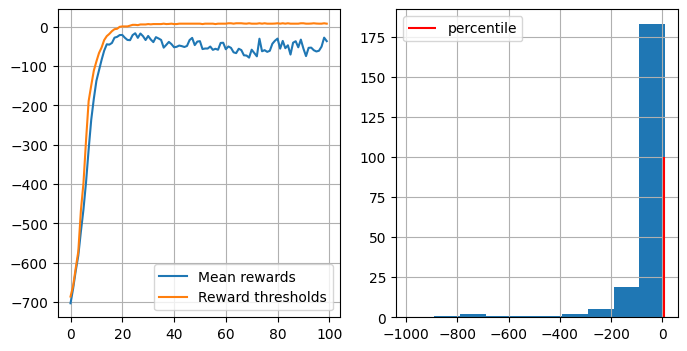

In [ ]:
n_sessions = 250  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):

    %time sessions = [generate_session(policy) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(np.array(states_batch,np.ndarray),np.array(actions_batch,np.ndarray),np.array(rewards_batch),percentile=50)

    new_policy = update_policy(elite_states,elite_actions)

    policy = policy*(1-learning_rate) + new_policy*learning_rate

    #display results on chart
    show_progress(rewards_batch,log,c_percentile = percentile)

# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [35]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.double]
policy = np.ones([n_states,n_actions])/n_actions
stepCounter = 100

# How do different percentiles affect training efficiency?

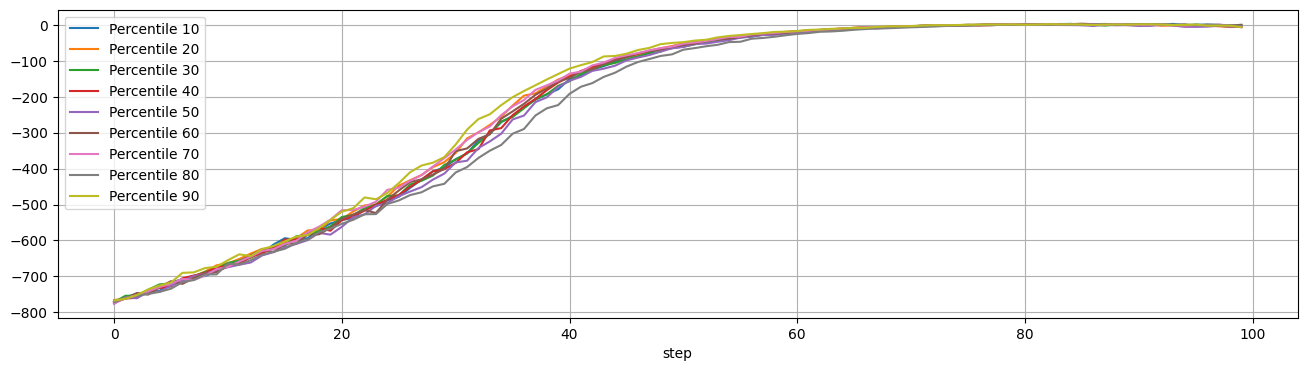

In [38]:
n_sessions = 500  #sample this many sessions
percentiles = [10,20,30,40,50,60,70,80,90]  #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []
mean = []
policies = [np.ones([n_states,n_actions])/n_actions for _ in range(len(percentiles))]

ys = [[] for _ in range(len(percentiles))]

for i in range(stepCounter):
    for p in range(len(percentiles)):
        %time sessions = [generate_session(policies[p]) for _ in range(n_sessions)]
        states_batch,actions_batch,rewards_batch = zip(*sessions)
        elite_states, elite_actions = select_elites(np.array(states_batch,np.ndarray),np.array(actions_batch,np.ndarray),np.array(rewards_batch),percentile=percentile)
        new_policy = update_policy(elite_states,elite_actions)
        policies[p] = policies[p]*(1-learning_rate) + new_policy*learning_rate
        ys[p].append(np.mean(rewards_batch))
    clear_output(True)
    plt.figure(figsize=[16,4])
    for p in range(len(percentiles)):
        plt.plot(ys[p],label='Percentile %i'%percentiles[p])
    plt.xlabel("step")
    plt.legend()
    plt.grid()
    plt.show()


# for percentile in percentiles:
#     curMean = []
#     policy = np.ones([n_states,n_actions])/n_actions
#     rewards_batch = np.array([])
#     for i in range(stepCounter):

#         %time sessions = [generate_session(policy) for _ in range(n_sessions)]

#         states_batch,actions_batch,rewards_batch = zip(*sessions)

#         elite_states, elite_actions = select_elites(np.array(states_batch,np.ndarray),np.array(actions_batch,np.ndarray),np.array(rewards_batch),percentile=percentile)

#         #set new policy
#         new_policy = update_policy(elite_states,elite_actions)
#         #update policy
#         policy = policy*(1-learning_rate) + new_policy*learning_rate
#         #add mean value
#         curMean.append(np.mean(rewards_batch))
#         clear_output(True)
#     mean.append(curMean)
#     #display results on chart
#     show_progress(rewards_batch,log, c_percentile = percentile)

# print(mean)

Ну, на таком графике особо разницы не видно

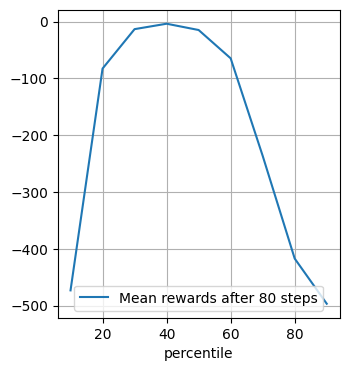

In [ ]:
def show_percentiles():
    clear_output(True)
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(percentiles, [x[-1] for x in mean], label ="Mean rewards after %i steps"%stepCounter)
    plt.legend()
    plt.grid()
    plt.xlabel("percentile")
    plt.show()
show_percentiles()

Как видно, наилучший результат достигается при percentile ≈ 40.

Make a graph with several training runs with different hyperparemeters

mean reward = 1.705, threshold=8.000


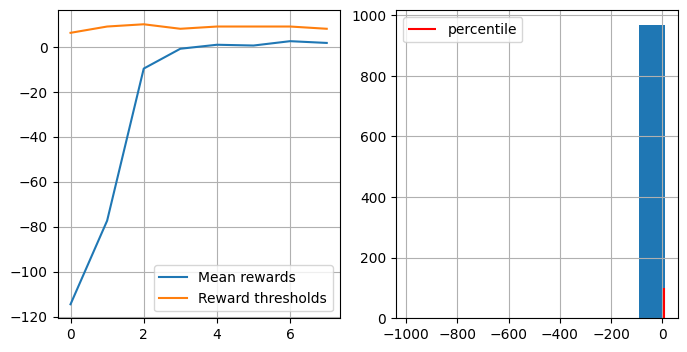

In [ ]:
n_sessions_ar = [50,100,200,300,400,500,750,1000]  #sample this many sessions
perc = 40  #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []
mean = []
for n_sessions in n_sessions_ar:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    rewards_batch = np.array([])
    for i in range(stepCounter):

        %time sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(np.array(states_batch, np.ndarray),
                                                    np.array(actions_batch, np.ndarray),np.array(rewards_batch),percentile=perc)

        #set new policy
        new_policy = update_policy(elite_states,elite_actions)
        #update policy
        policy = policy*(1-learning_rate) + new_policy*learning_rate
        #add mean value
        curMean.append(np.mean(rewards_batch))
        clear_output(True)
    mean.append(curMean)
    #display results on chart
    show_progress(rewards_batch,log,c_percentile=percentile)

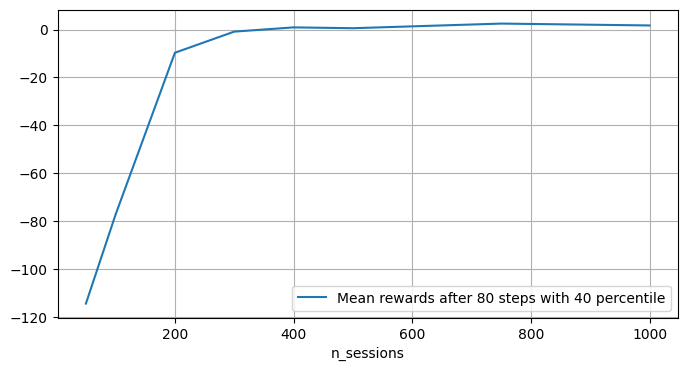

[-114.48, -77.31, -9.695, -0.8733333333333333, 0.8975, 0.554, 2.486666666666667, 1.705]


In [ ]:
def show_n_sessions():
    clear_output(True)
    plt.figure(figsize=[8,4])
    plt.plot(n_sessions_ar, [x[-1] for x in mean], label="Mean rewards after %i steps with %i percentile"%(stepCounter,perc))
    plt.legend()
    plt.grid()
    plt.xlabel("n_sessions")
    # plt.ylabel()
    plt.show()
show_n_sessions()
print([x[-1] for x in mean])

Как видно, результат максимален при 750 сессиях.


# Stabilize positive rewards by averaging policy across 10 games (4 pts)

In [25]:
def generate_sessions(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [], []
    total_reward = 0.
    for i in range(10):
        s = env.reset()
        for t in range(t_max):
            a = np.random.choice(range(n_actions), p = policy[s])
            new_s,r,done,info = env.step(a)
            states.append(s)
            actions.append(a)
            total_reward += r
            s = new_s
            if done:
                break
    return states, actions, total_reward / 10

learning rate = 0.200
percentile = 40.000
mean reward = 7.025, threshold=6.800


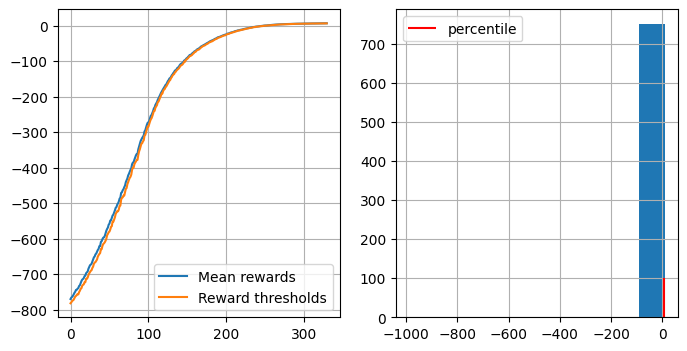

win!


In [26]:
n_sessions = 750  #sample this many sessions
percentile = 40  #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []
mean = []
policy = np.ones([n_states,n_actions])/n_actions
# policies = np.ones([10,n_states,n_actions])/n_actions
for i in range(1000):
    %time sessions = [generate_sessions(policy) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(np.array(states_batch, np.ndarray),np.array(actions_batch, np.ndarray),np.array(rewards_batch),percentile=percentile)

    new_policy = update_policy(elite_states,elite_actions)

    policy = policy * (1 - learning_rate) + new_policy * learning_rate

    show_progress(rewards_batch, log, learning_rate = learning_rate, c_percentile = percentile)

    if(np.mean(rewards_batch) > 7):
        print("win!")
        break

Замеченная проблема - если поставить просто полученные оптимальные n_swssions и percentile, то происходи следующее: Модель обучается до значения mean_reward ~ 3.5 за около 100 операций. А потом почему-то спускается до значений ~ -35 и держится на них до конца.

Картина была следующая:
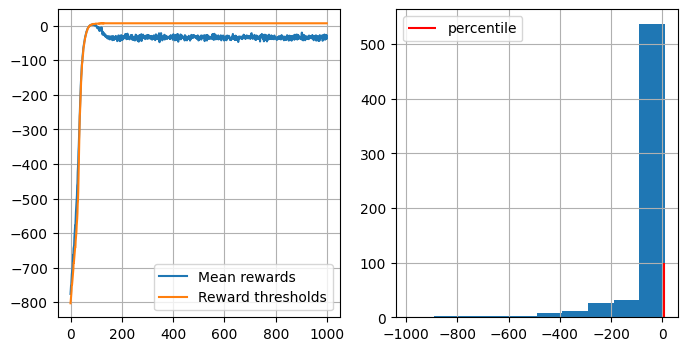

Первой мерой, которую я попробовал для решения проблемы - динамический learning rate. Я решил, что скорость обучения на каждом конкретном шаге будет зависить от того, на сколько этот шаг дал лучше рещультаты, чем предыдущей.
Использовал функцию sigmoid для этого.
Однако это только ускорило обучение до момента падения со 100 до 50 операций.

Далее было еще 4 часа увлекательнейшей игры с гиперпараметрами.

Но в итоге, на божьей силе, оно смогло набрать семь очков. Я просто задаю percentile 3-мя константами, в зависимости от полученного результата и learning_rate 2-мя константами, в зависимости от полученного результата.
А также увеличил ограничение по количеству итераций до 2000.

В итоге я понял, что нужно было по 10 играм обучаться. Он при первом же запуске неплохо и стабильно обучился. Хотя это было и дольше раза в 3)